In [1]:
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch
from torch import optim, nn
import os
import sys
from PIL import Image, ImageOps
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from os import path
import urllib.request
import pdb
from torch.utils import data

root = '/content/dataset'
train_dataset = torchvision.datasets.CIFAR10(root, train=True, transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.CIFAR10(root, train=False, transform=None, target_transform=None, download=True)

class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self,dataset):
    'Initialization'
    self.dataset=dataset
  def __len__(self):
    'Denotes the total number of samples'
    return len(self.dataset)
    #return 101
  def __getitem__(self, index):
    'Generates one sample of data'
    # Select sample
    x,label = (self.dataset[index])

    transform=transforms.Compose([transforms.ToTensor()])
    im = transform(x)
    return im, label

train_loader = Dataset(train_dataset)
test_loader = Dataset(test_dataset)
print(torch.cuda.memory_allocated(0)/1e9)
batch_size=1000
params={'batch_size':batch_size,'shuffle':True}
training_generator=data.DataLoader(train_loader,**params)
test_generator=data.DataLoader(test_loader,**params)

Files already downloaded and verified
Files already downloaded and verified
0.0


In [0]:
class resnet20(nn.Module):
  def __init__(self,x):
    super(resnet20,self).__init__()
    c=3
    out = 10
    channels=32
    #####Create the first block
    self.conv1=nn.Conv2d(c,channels,(3,3),padding=(1,1))

    #stage1
    self.conv2=nn.Conv2d(channels,channels,(3,3),padding=(1,1))
    #stage2
    self.conv3=nn.Conv2d(channels*2,channels*2,(3,3),padding=(1,1))
    #stage3
    self.conv4=nn.Conv2d(channels*4,channels*4,(3,3),padding=(1,1))
    #stage4
    self.conv5=nn.Conv2d(channels*8,channels*8,(3,3),padding=(1,1))


    self.convtrans1=nn.Conv2d(channels,channels*2,(3,3),padding=(1,1))
    self.convtrans2=nn.Conv2d(channels*2,channels*4,(3,3),padding=(1,1))
    self.convtrans3=nn.Conv2d(channels*4,channels*8,(3,3),padding=(1,1))
    
    self.bn1=nn.BatchNorm2d(channels)
    self.bn2=nn.BatchNorm2d(channels*2)
    self.bn3=nn.BatchNorm2d(channels*4)
    self.bn4=nn.BatchNorm2d(channels*8)
    self.activation = nn.ReLU()
    self.m1=nn.AvgPool2d(2,2)
    self.fc=nn.Linear(4096,10)


  
  def forward(self,x):

    
    def block(in1,stage):
      if stage==1:
        o2=self.activation(self.bn1(self.conv2(in1)))
        o3=self.conv2(o2)
        o4=in1 + o3
        o5 = self.activation(self.bn1(o4))
        return(o5)

      elif stage==1.5:

        trans1=self.m1(self.convtrans1(in1))
        trans2=self.activation(self.bn2(self.conv3(trans1)))
        trans3=self.conv3(trans2)
        trans4=trans1+trans3
        out=self.activation(self.bn2(trans4))
        return(out)

      elif stage==2:
        o2=self.activation(self.bn2(self.conv3(in1)))
        o3=self.conv3(o2)
        o4=in1 + o3
        o5 = self.activation(self.bn2(o4))
        return(o5)

      elif stage==2.5:
        trans1=self.m1(self.convtrans2(in1))
        trans2=self.activation(self.bn3(self.conv4(trans1)))
        trans3=self.conv4(trans2)
        trans4=trans1+trans3
        out=self.activation(self.bn3(trans4))
        return(out)

      elif stage==3:
        o2=self.activation(self.bn3(self.conv4(in1)))
        o3=self.conv4(o2)
        o4=in1 + o3
        o5 = self.activation(self.bn3(o4))
        return(o5)

      elif stage==3.5:
        trans1=self.m1(self.convtrans3(in1))
        trans2=self.activation(self.bn4(self.conv5(trans1)))
        trans3=self.conv5(trans2)
        trans4=trans1+trans3
        out=self.activation(self.bn4(trans4))
        return(out)

      elif stage==4:
        o2=self.activation(self.bn4(self.conv5(in1)))
        o3=self.conv5(o2)
        o4=in1 + o3
        o5 = self.activation(self.bn4(o4))
        return(o5)
    n,c,h,w = x.size()
    #3 channels

    o1=self.activation(self.bn1(self.conv1(x)))

    #32 channels - stage 1
    
    stage=1
    block1=block(o1,stage)
    block2=block(block1,stage)
    block3=block(block2,stage)

    #32 channels
    stage+=0.5

    block5=block(block3,stage)

    #64 channels - stage 2

    stage+=0.5
    
    block6=block(block5,stage)
    block7=block(block6,stage)
    block8=block(block7,stage)
    block8_5=block(block8,stage)

    #64 channels
    
    stage+=0.5

    block9=block(block8_5,stage)

    #128 channels - stage 3
    stage+=0.5
    
    block10=block(block9,stage)
    block11=block(block10,stage)
    block12=block(block11,stage)
    block13=block(block12,stage)
    block14=block(block13,stage)

    #128 channels 

    stage+=0.5

    block15=block(block14,stage)

    #256 channels - stage 4
    stage+=0.5
    
    block17=block(block15,stage)
    block18=block(block17,stage)
    block19=block(block18,stage)
    block20=block(block19,stage)
    #256 channels

    #fc 
    n,c,h,w=block20.size()
    vector = block20.view(n,c*h*w)

    out = (self.fc(vector))

    return out


for image,label in training_generator:
  model=resnet20(image.cuda())
  model=model.cuda()
  break

#define the objective function
objective = torch.nn.CrossEntropyLoss()

#define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

 85%|████████▌ | 51/60.0 [00:25<00:10,  1.12s/it]

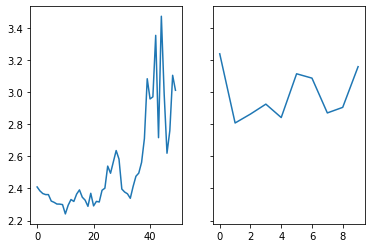

 85%|████████▌ | 51/60.0 [00:25<00:10,  1.11s/it]

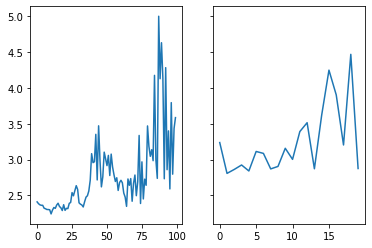

 85%|████████▌ | 51/60.0 [00:25<00:10,  1.11s/it]

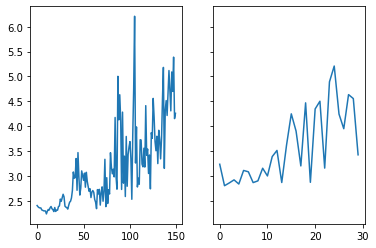

 85%|████████▌ | 51/60.0 [00:25<00:10,  1.12s/it]

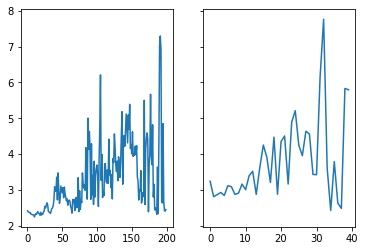

 85%|████████▌ | 51/60.0 [00:25<00:10,  1.11s/it]

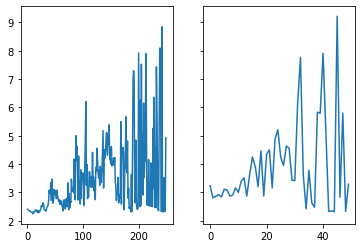

 85%|████████▌ | 51/60.0 [00:25<00:10,  1.11s/it]

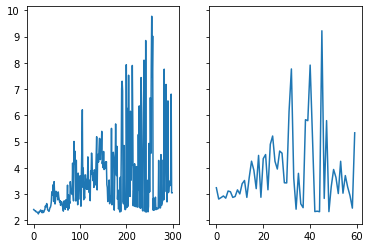

 85%|████████▌ | 51/60.0 [00:25<00:09,  1.10s/it]

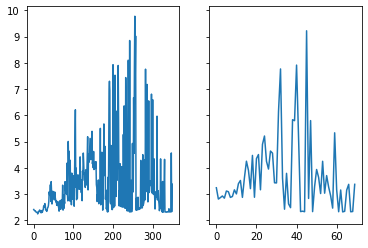

 85%|████████▌ | 51/60.0 [00:25<00:09,  1.10s/it]

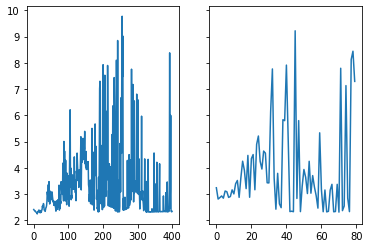

 85%|████████▌ | 51/60.0 [00:25<00:09,  1.11s/it]

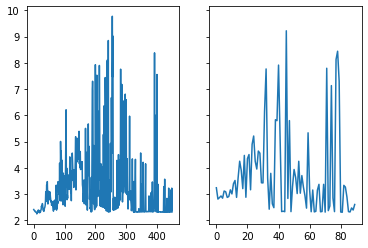

 85%|████████▌ | 51/60.0 [00:25<00:10,  1.11s/it]

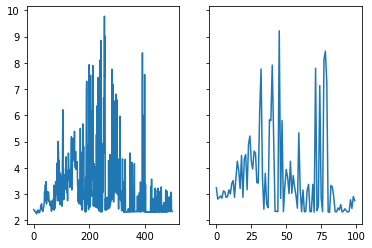

 85%|████████▌ | 51/60.0 [00:25<00:10,  1.12s/it]

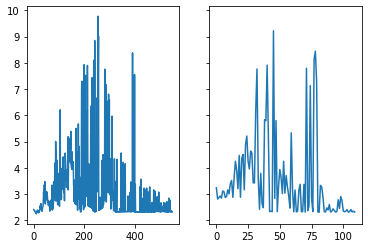

 85%|████████▌ | 51/60.0 [00:25<00:10,  1.11s/it]

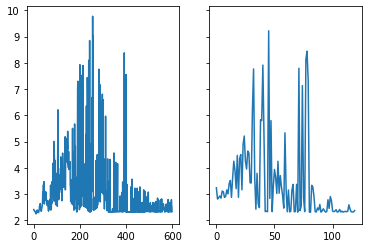

 85%|████████▌ | 51/60.0 [00:25<00:10,  1.12s/it]

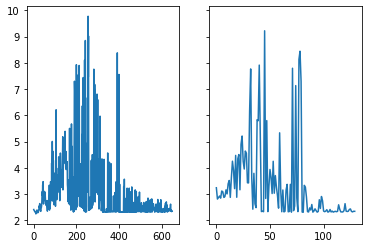

 85%|████████▌ | 51/60.0 [00:25<00:09,  1.11s/it]

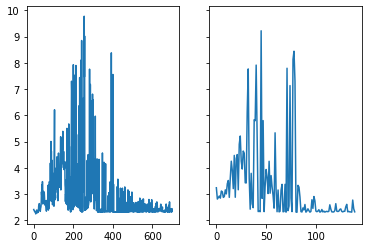

 85%|████████▌ | 51/60.0 [00:25<00:09,  1.11s/it]

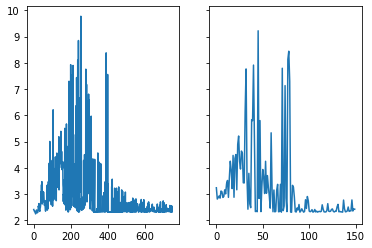

 85%|████████▌ | 51/60.0 [00:25<00:09,  1.10s/it]

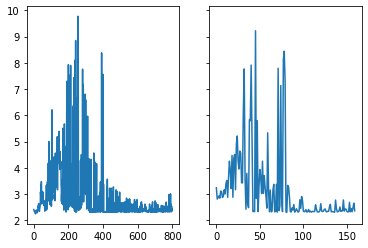

 85%|████████▌ | 51/60.0 [00:25<00:10,  1.11s/it]

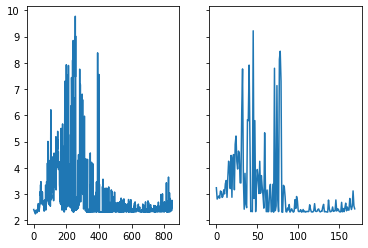

 85%|████████▌ | 51/60.0 [00:25<00:10,  1.11s/it]

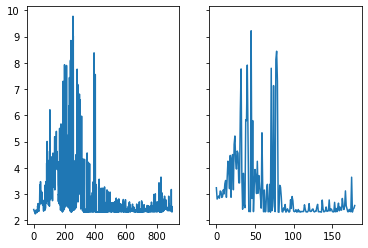

 85%|████████▌ | 51/60.0 [00:25<00:10,  1.12s/it]

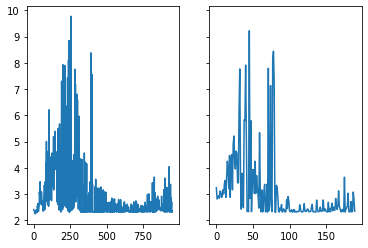

 85%|████████▌ | 51/60.0 [00:25<00:09,  1.10s/it]

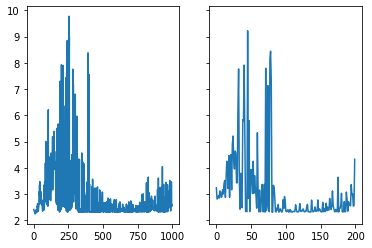

 13%|█▎        | 8/60.0 [00:03<00:23,  2.24it/s]

KeyboardInterrupt: ignored

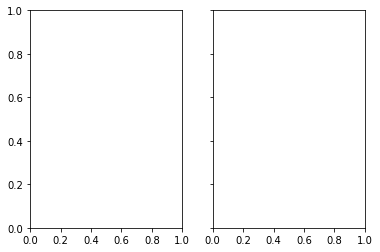

In [3]:
loss_train = []
loss_valid = []
from tqdm import tqdm
epochs=100

for epoch in range(epochs):
  fig,(ax1,ax2) = plt.subplots(1,2,sharey=True)
  loop = tqdm(total=(len(training_generator.dataset)/training_generator.batch_size)+(len(test_generator.dataset)/test_generator.batch_size), position = 0)
  for image,label in training_generator:
    yhat = model(image.cuda())
    loss=objective(yhat,label.cuda())
    try:
      loss.backward()
      optimizer.step()
      loss_train.append(loss)
      #print("train: " + str(loss))
    except:
      print('end of batch')
      loop.update(1)
    loop.update(1)
  with torch.no_grad():
    for image,label in test_generator:
      yhat = model(image.cuda())
      loss=objective(yhat,label.cuda())
      loss_valid.append(loss)  
    loop.update(1)   

  ax1.plot(loss_train)
  ax2.plot(loss_valid)
  plt.pause(0.5)
  plt.show()
  